In [1]:
# ============================================================
# UTA "True World" Generator – Step 1: Setup & Utilities
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass



# ---------- Dirichlet helper ----------
def dirichlet_positive(parts: int, alpha: float = 1.0) -> np.ndarray:
    """
    Draws a positive vector of given length that sums to 1.
    alpha = 1.0 -> uniform over the simplex
    alpha > 1.0 -> more balanced values
    alpha < 1.0 -> more extreme (one dominant weight)
    """
    return np.random.dirichlet(alpha * np.ones(parts))

# ---------- Breakpoints ----------
def uniform_breakpoints(L: int) -> np.ndarray:
    """Equally spaced breakpoints on [0, 100]."""
    return np.linspace(0.0, 100.0, L + 1)

# ---------- Direction transforms ----------
def to_z(x: np.ndarray, direction: int) -> np.ndarray:
    """Convert x in [0,100] into z domain so that utility is increasing in z."""
    return x if direction == +1 else 100.0 - x

def to_x(z: np.ndarray, direction: int) -> np.ndarray:
    """Inverse transform (for plotting in natural x scale)."""
    return z if direction == +1 else 100.0 - z

# ---------- Piecewise linear interpolation ----------
def piecewise_linear_eval(z_points: np.ndarray, u_points: np.ndarray, z: np.ndarray) -> np.ndarray:
    """Linear interpolation between breakpoints."""
    z = np.asarray(z, dtype=float)
    z_clamped = np.clip(z, z_points[0], z_points[-1])
    return np.interp(z_clamped, z_points, u_points)


In [2]:
# ============================================================
# Step 2: Generate criteria, weights, and true value functions
# ============================================================

@dataclass
class ValueFunction:
    """Represents a monotone piecewise-linear value function."""
    direction: int          # +1 = increasing, -1 = decreasing
    L: int                  # number of segments
    z_breaks: np.ndarray    # breakpoints in z-space (increasing)
    u_breaks: np.ndarray    # utility values (increasing)
    weight: float           # u(100) = w_i

np.random.seed(2)

# --- Parameters ---
# n_criteria = np.random.randint(3, 11)           # between 3 and 10 criteria
n_criteria = 4
directions = np.random.choice([+1, -1], size=n_criteria)  # +1 benefit / -1 cost
weights = dirichlet_positive(n_criteria)        # true criterion weights

value_functions: list[ValueFunction] = []

# L = np.random.randint(3, 7)               # between 3 and 6 segments
L = 5
z_breaks = uniform_breakpoints(L)

for i in range(n_criteria):
    # L_i = np.random.randint(3, 7)               # between 3 and 6 segments
    # z_breaks = uniform_breakpoints(L_i)
    delta = dirichlet_positive(L) * weights[i]  # positive increments summing to w_i
    u_breaks = np.concatenate(([0.0], np.cumsum(delta)))
    vf = ValueFunction(direction=directions[i], L=L, z_breaks=z_breaks, u_breaks=u_breaks, weight=weights[i])
    value_functions.append(vf)

print(f"Generated {n_criteria} criteria (benefit/cost mixed).")
for i, vf in enumerate(value_functions):
    dir_str = "↑ increasing" if vf.direction == +1 else "↓ decreasing"
    print(f"C{i+1}: L={vf.L}, weight={vf.weight:.3f}, {dir_str}")


Generated 4 criteria (benefit/cost mixed).
C1: L=5, weight=0.345, ↑ increasing
C2: L=5, weight=0.247, ↓ decreasing
C3: L=5, weight=0.236, ↓ decreasing
C4: L=5, weight=0.173, ↑ increasing



Top 5 alternatives (oracle ranking):
  #1: Alt 292, Score=0.846
  #2: Alt 456, Score=0.837
  #3: Alt 287, Score=0.812
  #4: Alt 185, Score=0.793
  #5: Alt 281, Score=0.773


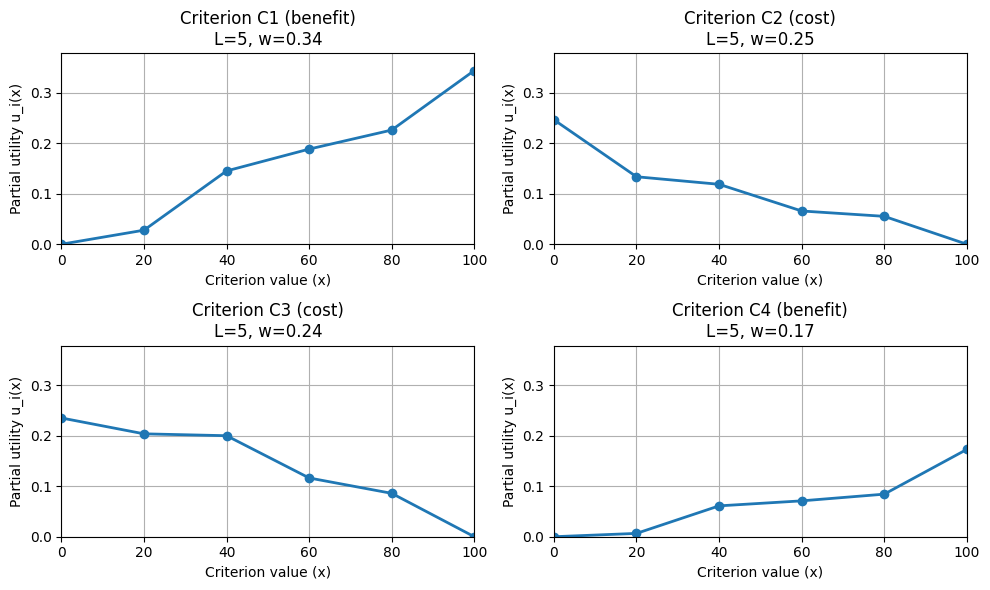

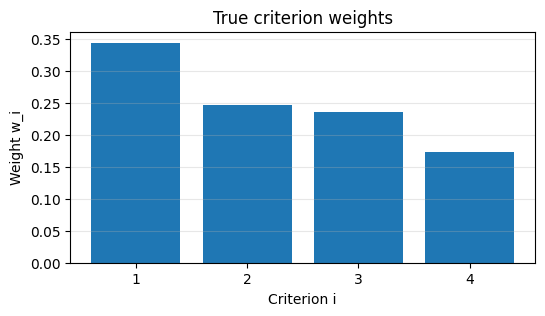

In [3]:
# ============================================================
# Step 3: Generate 30 random alternatives and visualize
# ============================================================

# --- Generate random alternatives in [0, 100] ---

n_alternatives = 500
X = np.random.randint(0, 101, size=(n_alternatives, n_criteria))

# --- Compute true scores ---
scores = []
for j in range(n_alternatives):
    total = 0.0
    for i, vf in enumerate(value_functions):
        z_val = to_z(X[j, i], vf.direction)
        total += piecewise_linear_eval(vf.z_breaks, vf.u_breaks, z_val)
    scores.append(total)

scores = np.array(scores)
ranking = np.argsort(-scores)  # descending order (best to worst)

print("\nTop 5 alternatives (oracle ranking):")
for rank in range(5):
    j = ranking[rank]
    print(f"  #{rank+1}: Alt {j+1:02d}, Score={scores[j]:.3f}")

# --- Visualization: value functions ---
fig, axes = plt.subplots(nrows=(n_criteria + 1)//2, ncols=2, figsize=(10, 3*((n_criteria+1)//2)))
axes = axes.flatten()

for i, (ax, vf) in enumerate(zip(axes, value_functions)):
    x_vals = to_x(vf.z_breaks, vf.direction)
    ax.plot(x_vals, vf.u_breaks, marker='o', linewidth=2)
    ax.set_title(f"Criterion C{i+1} ({'benefit' if vf.direction==1 else 'cost'})\nL={vf.L}, w={vf.weight:.2f}")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, max(weights)*1.1)
    ax.set_xlabel("Criterion value (x)")
    ax.set_ylabel("Partial utility u_i(x)")
    ax.grid(True)

for ax in axes[len(value_functions):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# --- Visualization: weights ---
plt.figure(figsize=(6,3))
plt.bar(range(1, n_criteria+1), weights)
plt.xticks(range(1, n_criteria+1))
plt.xlabel("Criterion i")
plt.ylabel("Weight w_i")
plt.title("True criterion weights")
plt.grid(axis='y', alpha=0.3)
plt.show()


In [4]:
# ============================================================
# Step 4: UTA Inference setup (user-controlled spec)
# - You choose the number of segments per criterion for inference (L_inf)
# - You choose which alternatives and ranking to feed the LP
# ============================================================

from typing import List, Tuple
from gurobipy import Model, GRB

n_alternatives = 500 # CHOOSE TOTAL NUMBER OF ALTERNATIVES GENERATED
alts_idx = np.arange(n_alternatives)

# alts_idx = np.random.choice(n_alternatives, 29, replace=False)
oracle_order = ranking.copy()               # best -> worst true



# Inference piece counts per criterion (can differ from the true ones)

# L_inf = [vf.L for vf in value_functions] # match the true L
L_inf = [5] * n_criteria # CHOOSE THE NUMBER OF SEGMENTS PER CRITERION 

# Build inference breakpoints IN Z-SPACE (increasing from 0 to 100)
z_breaks_inf = [np.linspace(0.0, 100.0, Li + 1) for Li in L_inf]

# Precompute (segment index, lambda) for each (criterion i, alternative j)
# using z-space values so that utility is increasing in z
def locate_segment_and_lambda(z_value: float, z_points: np.ndarray) -> Tuple[int, float]:
    """
    Locate the segment k (1..L) such that z in [z_{k-1}, z_k] and return (k, lambda),
    with linear interpolation parameter lambda in [0,1].
    If z is outside, it is clamped to the nearest endpoint.
    """
    if z_value <= z_points[0]:
        return 1, 0.0
    if z_value >= z_points[-1]:
        return len(z_points) - 1, 1.0
    # find k such that z_points[k-1] <= z_value <= z_points[k]
    k = np.searchsorted(z_points, z_value, side='right')
    k = min(max(1, k), len(z_points) - 1)
    denom = z_points[k] - z_points[k-1]
    lam = 0.0 if denom == 0 else (z_value - z_points[k-1]) / denom
    return k, lam

# For each criterion, convert x to z according to direction
Z = np.zeros((len(alts_idx), n_criteria))
for jj, j in enumerate(alts_idx):
    for i, vf in enumerate(value_functions):
        Z[jj, i] = to_z(X[j, i], vf.direction)

# For each criterion i and alt jj, store (k, λ) w.r.t. inference breakpoints
seg_lambda = [[None]*len(alts_idx) for _ in range(n_criteria)]
for i in range(n_criteria):
    for jj in range(len(alts_idx)):
        k, lam = locate_segment_and_lambda(Z[jj, i], z_breaks_inf[i])
        seg_lambda[i][jj] = (k, lam)

print("Inference spec ready: breakpoints per criterion and (k, λ) precomputed.")


Inference spec ready: breakpoints per criterion and (k, λ) precomputed.


In [5]:
# ============================================================
# Step 5: Build and solve the UTA inference LP
# - Variables u[i][k] at inference breakpoints (in z-space, monotone increasing)
# - Normalization: u_i(0)=0; sum_i u_i(100) = 1
# - Ranking constraints from oracle (consecutive pairs); L1 slacks for robustness
# ============================================================

EPS = 1e-6  # strictness margin
model = Model("UTA_inference")
model.Params.OutputFlag = 0

# Decision variables: u[i][k], k=0..L_inf[i]
u_vars = []
for i in range(n_criteria):
    ui = []
    for k in range(L_inf[i] + 1):
        ui.append(model.addVar(lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name=f"u_{i}_{k}"))
    u_vars.append(ui)

# Normalization: u_i(0)=0; sum_i u_i(100)=1
for i in range(n_criteria):
    model.addConstr(u_vars[i][0] == 0.0, name=f"norm_min_{i}")
model.addConstr(sum(u_vars[i][L_inf[i]] for i in range(n_criteria)) == 1.0, name="sum_weights")

# Monotonicity: u_i[k] >= u_i[k-1]
for i in range(n_criteria):
    for k in range(1, L_inf[i] + 1):
        model.addConstr(u_vars[i][k] >= u_vars[i][k-1], name=f"mono_{i}_{k}")

# Build inferred scores with slacks: s_hat[jj] = sum_i u_i(z_{ij}) - σ^+ + σ^-
sigma_p = [model.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"sigma_p_{jj}") for jj in range(len(alts_idx))]
sigma_m = [model.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"sigma_m_{jj}") for jj in range(len(alts_idx))]

s_hat = []
for jj in range(len(alts_idx)):
    expr = 0.0
    for i in range(n_criteria):
        k, lam = seg_lambda[i][jj]                # segment index 1..L, and lambda in [0,1]
        expr += (1 - lam) * u_vars[i][k-1] + lam * u_vars[i][k]
    expr = expr - sigma_p[jj] + sigma_m[jj]
    s_hat.append(expr)

# Ranking constraints from oracle, applied to consecutive pairs of the oracle order
# oracle_order is indices in original alt space; map to jj in alts_idx
pos_in_subset = {j: idx for idx, j in enumerate(alts_idx)}
consec_pairs = []
for t in range(len(oracle_order) - 1):
    j_best = oracle_order[t]
    j_next = oracle_order[t + 1]
    if j_best in pos_in_subset and j_next in pos_in_subset:
        jj_best = pos_in_subset[j_best]
        jj_next = pos_in_subset[j_next]
        model.addConstr(s_hat[jj_best] >= s_hat[jj_next] + EPS, name=f"rank_{j_best}_gt_{j_next}")
        consec_pairs.append((jj_best, jj_next))

# Objective: minimize sum of L1 slacks
model.setObjective(sum(sigma_p) + sum(sigma_m), GRB.MINIMIZE)
model.optimize()

print(f"LP status: {model.Status} (2=optimal). Objective (total slack) = {model.ObjVal:.6e}")

# Extract inferred value functions (u_breaks) and weights
u_inf_breaks = []
w_inf = []
for i in range(n_criteria):
    vals = np.array([u_vars[i][k].X for k in range(L_inf[i] + 1)])
    u_inf_breaks.append(vals)
    w_inf.append(vals[-1])

u_inf_breaks = [np.array(v) for v in u_inf_breaks]
w_inf = np.array(w_inf)

print("Inferred weights (sum ~ 1):", np.round(w_inf, 6), "sum=", np.round(w_inf.sum(), 6))


Restricted license - for non-production use only - expires 2026-11-23
LP status: 2 (2=optimal). Objective (total slack) = 0.000000e+00
Inferred weights (sum ~ 1): [0.344447 0.24674  0.235611 0.173202] sum= 1.0


Kendall tau : 0.9999999999999999


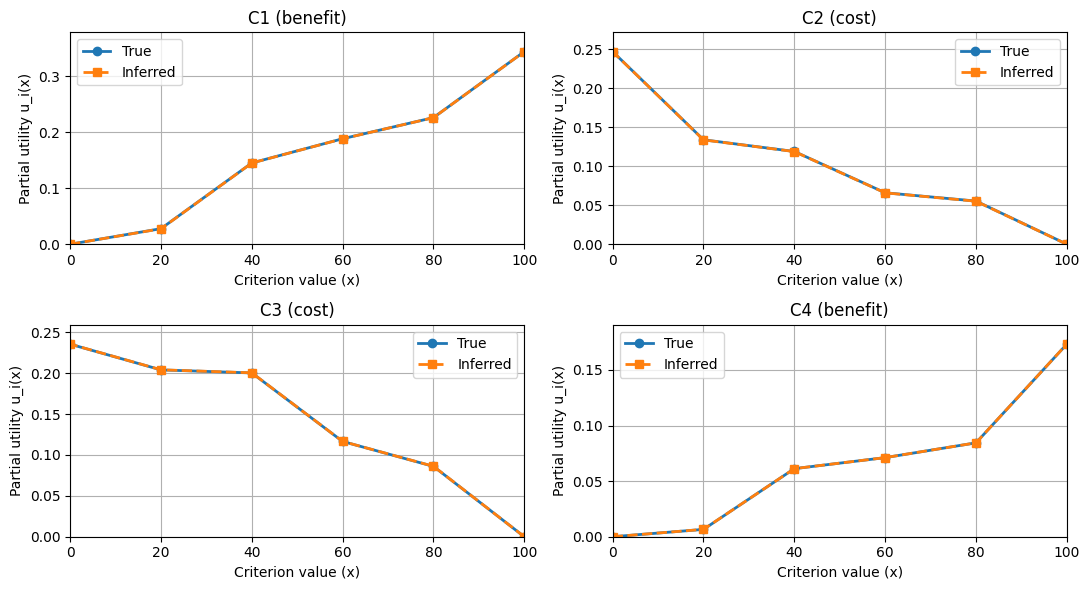

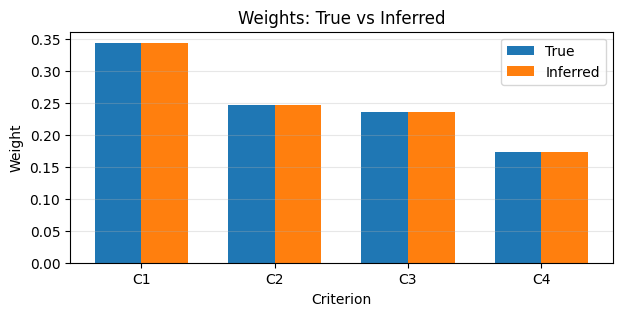

In [6]:
# ============================================================
# Step 6: Compare oracle vs inferred
# - Compute inferred scores for all provided alternatives
# - Ranking agreement (Kendall tau, Spearman rho)
# - Plot value functions: true vs inferred
# - Compare weights
# ============================================================

from scipy.stats import kendalltau


# Compute inferred scores numerically (without slacks)
def inferred_score_row(z_row: np.ndarray) -> float:
    total = 0.0
    for i in range(n_criteria):
        # interpolate on inferred breakpoints in z
        total += piecewise_linear_eval(z_breaks_inf[i], u_inf_breaks[i], z_row[i])
    return total

s_inferred = np.array([inferred_score_row(Z[jj, :]) for jj in range(len(alts_idx))])

# Rankings within the provided subset
oracle_rank_subset = np.argsort(-scores[alts_idx])     # best->worst using oracle scores
inferred_rank_subset = np.argsort(-s_inferred)         # best->worst using inferred scores


tau, p_value = kendalltau(oracle_rank_subset, inferred_rank_subset)

print(f"Kendall tau : {tau}")



# ---- Plot: value functions (true vs inferred) ----
rows = (n_criteria + 1)//2
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(11, 3*rows))
axes = axes.flatten()

for i, ax in enumerate(axes[:n_criteria]):
    # True function: in x-scale for readability
    x_true = to_x(value_functions[i].z_breaks, value_functions[i].direction)
    u_true = value_functions[i].u_breaks

    # Inferred function: also plot in x-scale (convert z_breaks_inf -> x via same direction)
    x_inf = to_x(z_breaks_inf[i], value_functions[i].direction)
    u_inf = u_inf_breaks[i]

    ax.plot(x_true, u_true, marker='o', linewidth=2, label='True')
    ax.plot(x_inf,  u_inf,  marker='s', linestyle='--', linewidth=2, label='Inferred')
    ax.set_title(f"C{i+1} ({'benefit' if value_functions[i].direction==1 else 'cost'})")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, max(max(u_true), max(u_inf)) * 1.1 if max(u_inf) > 0 else max(u_true)*1.1)
    ax.set_xlabel("Criterion value (x)")
    ax.set_ylabel("Partial utility u_i(x)")
    ax.grid(True)
    ax.legend()

for ax in axes[n_criteria:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# ---- Plot: weights comparison ----
plt.figure(figsize=(7,3))
idx = np.arange(n_criteria)
barw = 0.35
plt.bar(idx - barw/2, [vf.weight for vf in value_functions], width=barw, label="True")
plt.bar(idx + barw/2, w_inf, width=barw, label="Inferred")
plt.xticks(idx, [f"C{i+1}" for i in range(n_criteria)])
plt.xlabel("Criterion")
plt.ylabel("Weight")
plt.title("Weights: True vs Inferred")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


In [7]:
import numpy as np
from scipy.stats import kendalltau

def additive_score_true(X):
    scores = []
    for x in X:
        s = 0
        for j, vf in enumerate(value_functions):
            z = to_z(x[j], vf.direction)
            s += piecewise_linear_eval(vf.z_breaks, vf.u_breaks, z)
        scores.append(s)
    return np.array(scores)

def additive_score_inf(X):
    scores = []
    for x in X:
        s = 0
        for j in range(n_criteria):
            z = to_z(x[j], value_functions[j].direction)
            s += piecewise_linear_eval(z_breaks_inf[j], u_inf_breaks[j], z)
        scores.append(s)
    return np.array(scores)

def ranking_from_scores(s):
    return np.argsort(-s)

def run_once(n=30):
    X = np.random.randint(0, 101, size=(n, n_criteria))
    true_scores = additive_score_true(X)
    inf_scores  = additive_score_inf(X)
    r_true = np.argsort(-true_scores)
    r_inf  = np.argsort(-inf_scores)
    tau, _ = kendalltau(r_true, r_inf)
    acc = (tau + 1) / 2 * 100  # convert to % pairwise accuracy
    return acc

In [12]:
N_list = [30, 50, 100, 1000]   # tailles d'échantillons
M = 100                  # nombre de répétitions (mettre 10 ou 100 selon ton besoin)

results = {}            # dictionnaire -> stocker liste des accuracies pour chaque N

for N in N_list:
    accs = [run_once(n=N) for _ in range(M)]  # run M fois avec N alternatives
    accs = np.array(accs, float)

    results[N] = accs  # stockage brut, utile si tu veux tracer ou analyser ensuite

    print(f"\n--- N = {N}, M = {M} runs ---")
    print(f"Mean accuracy: {np.mean(accs):.2f}%")


--- N = 30, M = 100 runs ---
Mean accuracy: 99.82%

--- N = 50, M = 100 runs ---
Mean accuracy: 99.54%

--- N = 100, M = 100 runs ---
Mean accuracy: 98.99%

--- N = 1000, M = 100 runs ---
Mean accuracy: 91.94%
